In [15]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
tfds.disable_progress_bar()


In [16]:
embedding_layer = layers.Embedding(1000, 5)
result = embedding_layer(tf.constant([1,2,3]))
result.numpy()

array([[-0.00996789,  0.03989991, -0.03156505, -0.01507553, -0.00014274],
       [ 0.04330163, -0.01814052,  0.00914363,  0.03328938,  0.02930907],
       [ 0.03289524, -0.03335796, -0.02889103,  0.04464804,  0.03173259]],
      dtype=float32)

In [17]:
result = embedding_layer(tf.constant([[0,1,2],[3,4,5]]))
result.shape


TensorShape([2, 3, 5])

In [18]:
#Learning embeddings from scratch
(train_data, test_data), info = tfds.load(
    'imdb_reviews/subwords8k',
    split = (tfds.Split.TRAIN, tfds.Split.TEST),
    with_info=True, as_supervised=True
)


In [20]:
encoder = info.features['text'].encoder

In [21]:
train_batches = train_data.shuffle(1000).padded_batch(10)
test_batches = test_data.shuffle(1000).padded_batch(10)


In [24]:
embedding_dim = 16
model = keras.Sequential([
    layers.Embedding(encoder.vocab_size, embedding_dim),
    layers.GlobalAveragePooling1D(),
    layers.Dense(16, activation='relu'),
    layers.Dense(1)
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 16)          130960    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 131,249
Trainable params: 131,249
Non-trainable params: 0
_________________________________________________________________


In [25]:
model.compile(optimizer='adam',
             loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
             metrics=['accuracy'])
history = model.fit(
    train_batches, epochs=10, validation_data=test_batches, validation_steps=20)

Epoch 1/10
2500/2500 [==============================] - 10s 4ms/step - loss: 0.5123 - accuracy: 0.6917 - val_loss: 0.3824 - val_accuracy: 0.8250
Epoch 2/10
2500/2500 [==============================] - 9s 4ms/step - loss: 0.2866 - accuracy: 0.8804 - val_loss: 0.3132 - val_accuracy: 0.8800
Epoch 3/10
2500/2500 [==============================] - 10s 4ms/step - loss: 0.2324 - accuracy: 0.9080 - val_loss: 0.4628 - val_accuracy: 0.8450
Epoch 4/10
2500/2500 [==============================] - 11s 4ms/step - loss: 0.1993 - accuracy: 0.9227 - val_loss: 0.3919 - val_accuracy: 0.8150
Epoch 5/10
2500/2500 [==============================] - 10s 4ms/step - loss: 0.1755 - accuracy: 0.9340 - val_loss: 0.3647 - val_accuracy: 0.8400
Epoch 6/10
2500/2500 [==============================] - 11s 4ms/step - loss: 0.1566 - accuracy: 0.9428 - val_loss: 0.4531 - val_accuracy: 0.8500
Epoch 7/10
2500/2500 [==============================] - 11s 5ms/step - loss: 0.1444 - accuracy: 0.9472 - val_loss: 0.4897 - val_acc

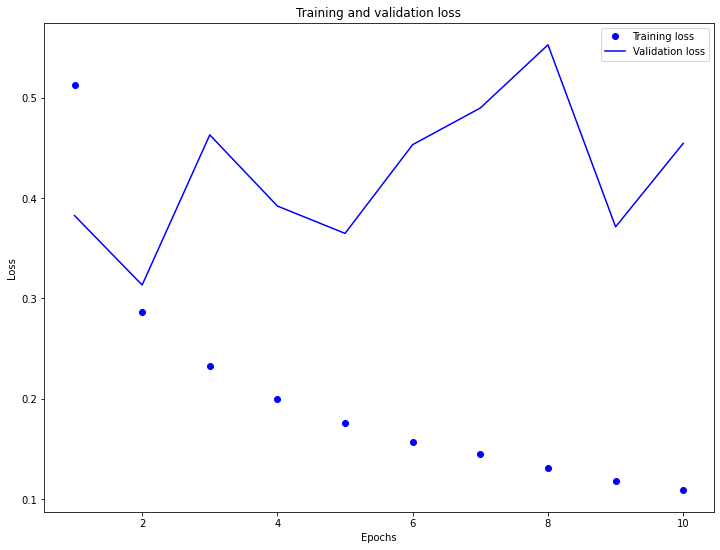

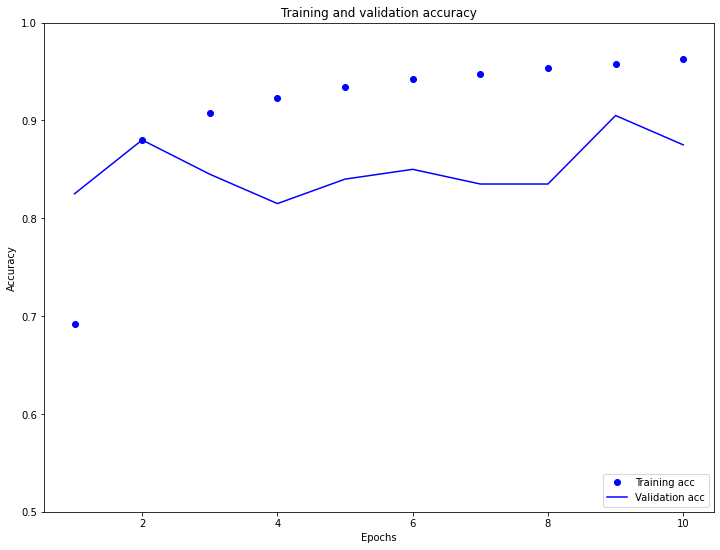

In [26]:
import matplotlib.pyplot as plt

history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss=history_dict['loss']
val_loss=history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim((0.5,1))
plt.show()

In [27]:
#Retrieve the learned embeddings
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape)

(8185, 16)


In [ ]:
import io
out_v = io.open("vecs.tsv", 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

for num, word in enumerate(encoder.subwords):
    vec = weights[num+1] # skip 0, it's padding.
    out_m.write(word+'\n')
    out_v.write('\t'.join([str(x) for x in vec]) + '\n')
out_v.close()
out_m.close()